In [1]:
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import morphs
import numpy as np
import scipy as sp

/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
folder = morphs.paths.FIGURES_DIR / "psychometrics"

In [3]:
for path in morphs.paths.PROCESSED_DIR.glob("psychometrics_shuffled_*.pkl"):
    num_shuffles = morphs.data.parse.num_shuffles(path)
    print(num_shuffles, path.name)

1024 psychometrics_shuffled_1024.pkl
131072 psychometrics_shuffled_131072.pkl


In [4]:
distributions = morphs.load.psychometric_param_pdists()
null_kstats = morphs.load.psychometric_param_shuffled_pdists(num_shuffles)

In [5]:
def label_maker(split, p, num_shuffles=num_shuffles, bonferroni_n=8):
    if p == 0:
        p_str = "p<%.E" % (1.0 / num_shuffles)
    elif p > 0.001:
        p_str = "p=%.03f" % (p)
    else:
        p_str = "p=%.E" % (p)
    sig_str = morphs.data.parse.p_value(p, bonferroni_n=bonferroni_n)
    return "%s %s%s" % (split, p_str, sig_str)

In [6]:
def plot_param_dists(
    distributions,
    null_kstats,
    params=["B", "M", "A", "K"],
    legend=False,
    log=True,
    verbose=False,
    split_color_map=None,
    figsize=5,
    target_length=1000,
):
    bottom = 1 / num_shuffles if log else 0
    xmax = 0
    if not split_color_map:
        cmap = sns.color_palette()
        split_color_map = {"dim": cmap[0], "subj": cmap[3]}

    if len(params) == 1:
        rows, cols = 1, 1
    if len(params) == 2:
        rows, cols = 1, 2
    else:
        rows, cols = 2, 2
    fig, axes = plt.subplots(
        rows, cols, figsize=(figsize * cols * 1.1, figsize * rows), sharey="row"
    )
    for i, param in enumerate(params):
        ax = axes.flat[i]
        plt.sca(ax)
        if log:
            ax.set_yscale("log")
        for split in null_kstats[param]:
            p = (
                np.sum(
                    sp.stats.mstats.ks_twosamp(
                        distributions[param][split],
                        distributions[param]["null_dist"],
                        alternative="greater",
                    )[0]
                    < null_kstats[param][split]
                )
                / num_shuffles
            )
            morphs.plot.cumulative_distribution(
                null_kstats[param][split],
                label=label_maker(split, p),
                color=split_color_map[split],
                scaled=True,
                survival=True,
                fill=True,
                target_length=target_length,
            )
            d = sp.stats.mstats.ks_twosamp(
                distributions[param][split],
                distributions[param]["null_dist"],
                alternative="greater",
            )[0]
            if verbose:
                print(param, split, d, p)
            p = max(p, bottom)
            ax.axvline(x=d, color=split_color_map[split], ls="-")
            ax.axhline(y=p, color=split_color_map[split], ls="--")
            ax.annotate(
                morphs.data.parse.p_value(p, bonferroni_n=8),
                (d, p),
                fontsize="xx-large",
                color=split_color_map[split],
            )
            xmax = max(xmax, d * 1.15)
        ax.set_xlabel("KS-stat between pairwise distances of %s parameters" % (param))
    for ax in axes.flat:
        ax.set_xlim([0, xmax])
        ax.set_ylim([bottom, 1])
        if legend:
            ax.legend(title="grouped by:")
    if rows == 1:
        axes[0].set_ylabel("Shuffled cumulative survival (p value)")
    else:
        for i in range(axes.shape[0]):
            axes[i, 0].set_ylabel("Shuffled cumulative survival (p value)")

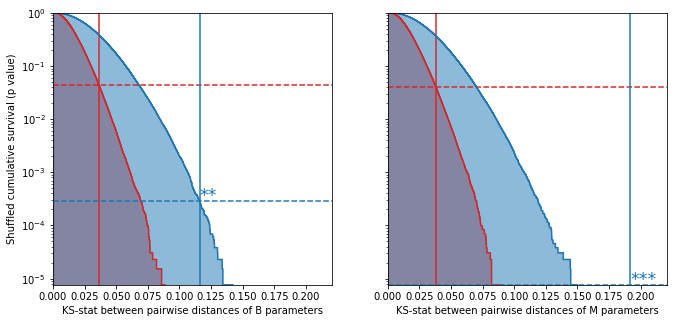

In [7]:
plot_param_dists(distributions, null_kstats, params=["B", "M"])
morphs.plot.savefig(plt.gcf(), "psyc-conserved-stats-BM", folder=folder)

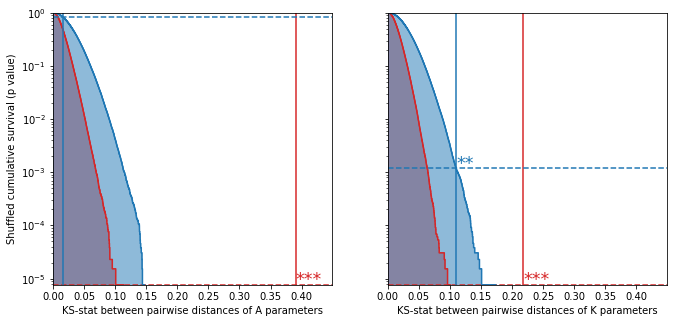

In [8]:
plot_param_dists(distributions, null_kstats, params=["A", "K"])
morphs.plot.savefig(plt.gcf(), "psyc-conserved-stats-AK", folder=folder)

B subj 0.03637631233595885 0.044281005859375
B dim 0.11593667979002717 0.0002899169921875
M subj 0.037926509186352854 0.04128265380859375
M dim 0.19180610236220458 0.0
A subj 0.39015748031491215 0.0
A dim 0.0156796806649189 0.843780517578125
K subj 0.21816765091863435 0.0
K dim 0.11014052930883722 0.00118255615234375


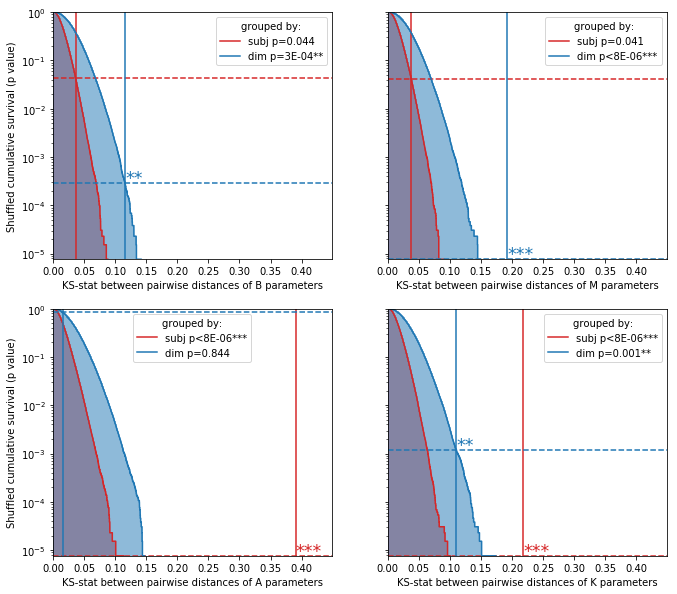

In [9]:
plot_param_dists(distributions, null_kstats, legend=True, verbose=True, target_length=np.inf)

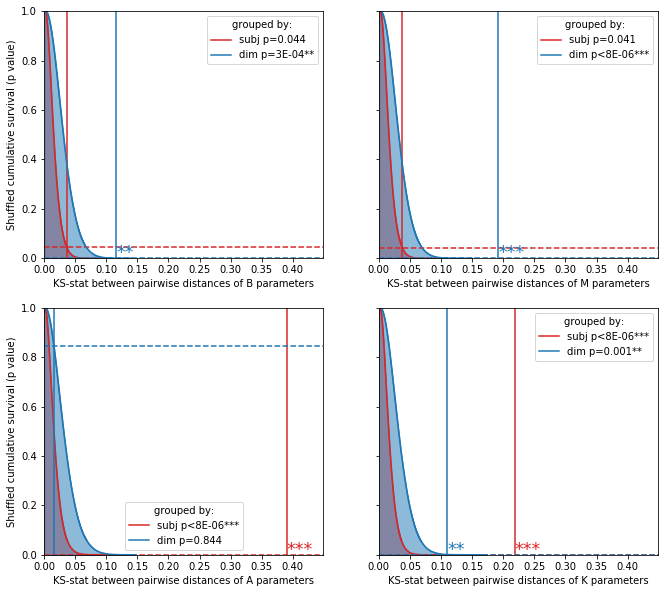

In [10]:
plot_param_dists(distributions, null_kstats, log=False, legend=True)

In [11]:
def range_dists(distributions):
    eps = 1e-6
    smallest = np.amin([np.amin(distributions[dist]) for dist in distributions])
    largest = np.amax([np.amax(distributions[dist]) for dist in distributions])
    largest += eps
    if smallest > 0 and smallest * 20 < largest:
        smallest = 0
    return smallest, largest

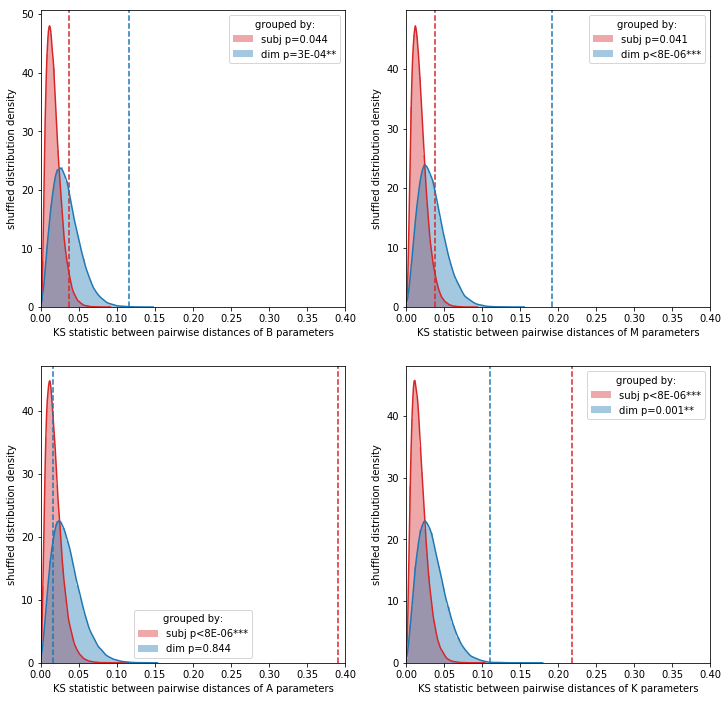

In [12]:
num_bins = 80
cmap = sns.color_palette()
split_color_map = {"dim": cmap[0], "subj": cmap[3]}
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, param in enumerate(["B", "M", "A", "K"]):
    ax = axes.flatten()[i]
    dist_range = range_dists(null_kstats[param])
    bins = np.linspace(*dist_range, num=num_bins)
    for split in null_kstats[param]:
        p = (
            np.float(
                np.sum(
                    sp.stats.mstats.ks_twosamp(
                        distributions[param][split],
                        distributions[param]["null_dist"],
                        alternative="greater",
                    )[0]
                    < null_kstats[param][split]
                )
            )
            / num_shuffles
        )
        sns.distplot(
            null_kstats[param][split],
            ax=ax,
            label=label_maker(split, p),
            bins=bins,
            color=split_color_map[split],
        )
        d = sp.stats.mstats.ks_twosamp(
            distributions[param][split],
            distributions[param]["null_dist"],
            alternative="greater",
        )[0]
        ax.axvline(x=d, color=split_color_map[split], ls="--")
    #     ax.set_title('KS statistic for %s parameter' % (param))
    ax.legend(title="grouped by:")
    ax.set_xlim([0, 0.4])
    ax.set_xlabel("KS statistic between pairwise distances of %s parameters" % (param))
    ax.set_ylabel("shuffled distribution density")